In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, median_absolute_error

https://www.kaggle.com/datasets/devansodariya/student-performance-data

In [ ]:
df = pd.read_csv('https://dl.uploadgram.me/62e85bf854ec4h?raw')
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [ ]:
df.dtypes

school        object
sex           object
age            int64
address       object
famsize       object
Pstatus       object
Medu           int64
Fedu           int64
Mjob          object
Fjob          object
reason        object
guardian      object
traveltime     int64
studytime      int64
failures       int64
schoolsup     object
famsup        object
paid          object
activities    object
nursery       object
higher        object
internet      object
romantic      object
famrel         int64
freetime       int64
goout          int64
Dalc           int64
Walc           int64
health         int64
absences       int64
G1             int64
G2             int64
G3             int64
dtype: object

In [ ]:
df['G1'] = df['G1'].astype(int)
df['G2'] = df['G2'].astype(int)
df['G3'] = df['G3'].astype(int)

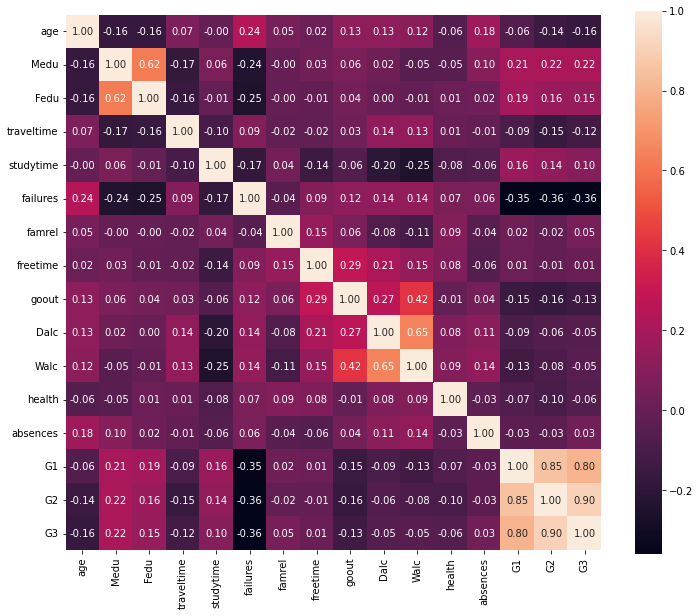

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.subplots(figsize=(12, 10))
sns.heatmap(df.corr(),fmt='.2f', square = True, annot=True)
plt.show()

## Подготовка данных

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = ['G1', 'G2', 'G3']), df['G3'], test_size=0.2, random_state=42)

In [ ]:
categorical_features = df.drop(columns=['G1', 'G2', 'G3']).select_dtypes(include= object).columns.values
categorical_features

array(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
       'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'romantic'], dtype=object)

In [ ]:
numeric_features = df.drop(columns=['G1', 'G2', 'G3']).select_dtypes(exclude= object).columns.values
numeric_features

array(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
       'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health',
       'absences'], dtype=object)

In [ ]:
from sklearn.pipeline import make_pipeline # конвейер подготовки данных
from sklearn.pipeline import Pipeline # конвер алгоритмов
from sklearn.impute import SimpleImputer # пропуски заполняются медианными значениями
from sklearn.preprocessing import OneHotEncoder, StandardScaler # onehot encoding и стандартизации
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
# конвейер подготовки данных числового типа
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"),
                                    StandardScaler())

# конвейер подготовки данных категориального типа
preprocessor = ColumnTransformer(
    [
        ('num', numeric_transformer, numeric_features),
        (
            'cat',
            OneHotEncoder(handle_unknown='ignore', sparse=False),
            categorical_features
        )
    ],
    verbose_feature_names_out = False,
)
# подготовка и обучение алгоритма
alg = Pipeline(steps=[
    ('enc', preprocessor), # подготовка
    ('alg', RandomForestRegressor()) # алгоритм
])

# обучение алгоритма
alg.fit(X_train, y_train)

Pipeline(steps=[('enc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  array(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
       'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health',
       'absences'], dtype=object)),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  array(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', '

In [ ]:
# предсказания
preds = alg.predict(X_test)

# коэффициент детерминации и медианна абсолютная ошибка
r2_score(y_test, preds), median_absolute_error(y_test, preds)

(0.29472844450348523, 2.4000000000000004)

In [ ]:
# среднее и стандартное отклонение целевой переменной
y_test.mean(), y_test.std()

(10.772151898734178, 4.55718471092093)

## Grid search

Гиперапараметры решающего леса: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [ ]:
parameters = {
    # название этпапа подготовки__гиперпараметр: [сетка (список) параметров]
    'alg__n_estimators': [100, 300, 500, 1000],
    'alg__min_samples_leaf': [1, 2, 4, 6],
    'alg__max_features': ['auto', 'sqrt', 'log2']
}

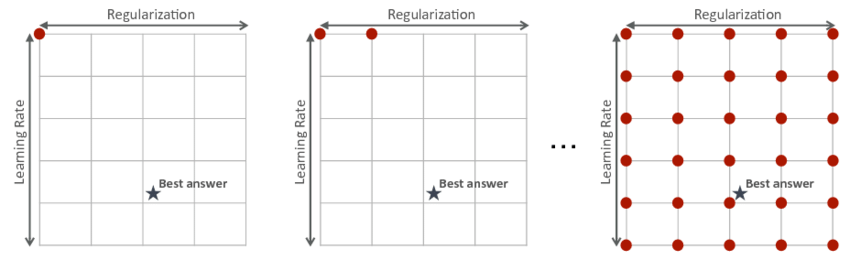

In [ ]:
from sklearn.model_selection import GridSearchCV
# сетка гиперпараметров
gs = GridSearchCV(alg, # выбор алгоритма или пайплайна (подготовка + алгоритм)
                  parameters, # сетка гиперпараметров
                  cv=5, # количество фолдов кросс-валидации
                  verbose=2, # отображать процесс перебора гиперпараметров
                  n_jobs=2) # параллелизм вычислений

gs.fit(X_train, y_train)
gs.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'alg__max_features': 'auto',
 'alg__min_samples_leaf': 1,
 'alg__n_estimators': 1000}

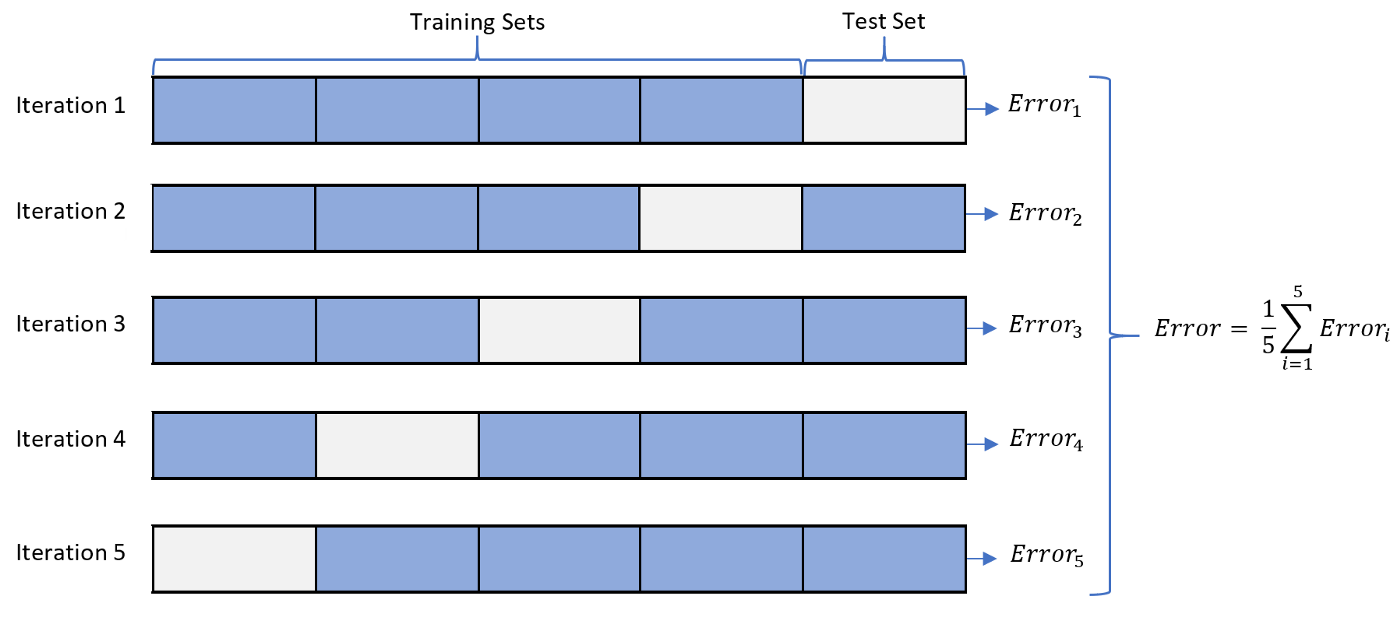

In [ ]:
gs.cv_results_

{'mean_fit_time': array([0.90240073, 2.43733191, 2.13121457, 4.22873402, 0.38859839,
        1.13104453, 1.87744527, 3.72577014, 0.33364029, 0.98119626,
        1.59643397, 3.210501  , 0.31151423, 0.89779115, 1.48921232,
        2.94210835, 0.25866561, 0.76003733, 1.21794958, 2.39568806,
        0.24891148, 1.03168111, 1.28712063, 2.25772915, 0.23376865,
        0.66445446, 1.08162551, 2.12865124, 0.23061671, 0.88492751,
        1.04944386, 2.07473435, 0.24774346, 0.72489057, 1.17166529,
        2.318401  , 0.23781261, 0.66954002, 1.09757309, 2.14869714,
        0.22731609, 0.64532027, 1.06648216, 2.0819191 , 0.23509808,
        0.62946572, 1.04842577, 1.96845865]),
 'mean_score_time': array([0.0535336 , 0.1143352 , 0.08107162, 0.15760036, 0.02551708,
        0.05495996, 0.08565207, 0.15191846, 0.02774167, 0.05629296,
        0.08850384, 0.1526176 , 0.02464299, 0.05640202, 0.08007631,
        0.15263686, 0.02838736, 0.05996399, 0.08539577, 0.15881972,
        0.02900233, 0.08696017, 0.

Модуль кросс-валидации

In [ ]:
preds = gs.best_estimator_.predict(X_test)

r2_score(y_test, preds), median_absolute_error(y_test, preds)

(0.29946759506767107, 2.369999999999999)